# Tackling the Challenge of Dermatological Image Classification with CNNs on IBM LinuxONE - CodeHnt TUT33 <a class="anchor" id="intro"></a>


The accurate and timely diagnosis of pigmented skin lesions is crucial for preventing the progression of skin cancer, a significant global health concern. Traditional diagnostic methods, often rely on visual inspection and invasive procedures, can be time-consuming and prone to human error and pathologist skill level. To address these limitations, researchers have increasingly turned to deep learning techniques, particularly Convolutional Neural Networks (CNNs), for automated diagnosis.

However, a major obstacle in training effective CNN models for this task is the scarcity and lack of diversity in available dermatoscopic image datasets. Small datasets can lead to overfitting and limited generalization capabilities, hindering the model's ability to accurately classify unseen images. 

## Goal
The automated predictions of disease classification within dermoscopic images. Our aim is to get a respectable accuracy in the 80th percentile given the quick turn around and limited time with the dataset.


## Table of Contents

1. [Tackling the Challenge of Dermatological Image Classification with CNNs on IBM LinuxONE](#intro) 
2. [Package management](#prep)
3. [Data Exploratin](#exp)
4. [Splitting dataset for training, validation and testing](#split)
5. [Image Preprocessing](#process)
6. [Training, validating and testing CNN](#cnn)
7. [Conclusion](#conclusion)



We herein use data generously provided by:

[1] Noel Codella, Veronica Rotemberg, Philipp Tschandl, M. Emre Celebi, Stephen Dusza, David Gutman, Brian Helba, Aadi Kalloo, Konstantinos Liopyris, Michael Marchetti, Harald Kittler, Allan Halpern: “Skin Lesion Analysis Toward Melanoma Detection 2018: A Challenge Hosted by the International Skin Imaging Collaboration (ISIC)”, 2018; https://arxiv.org/abs/1902.03368
[2] Tschandl, P., Rosendahl, C. & Kittler, H. The HAM10000 dataset, a large collection of multi-source dermatoscopic images of common pigmented skin lesions. Sci. Data 5, 180161 doi:10.1038/sdata.2018.161 (2018).

## Package management <a class="anchor" id="prep"></a>

In [1]:
import sys
!{sys.executable} -m pip install torch torchvision --index-url https://download.pytorch.org/whl/cpu
!pip install kagglehub numpy pandas matplotlib seaborn pillow scikit-learn tqdm scikit-image keras-tuner

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://download.pytorch.org/whl/cpu
Defaulting to user installation because normal site-packages is not writeable


In [2]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

import kagglehub as kh

import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau, StepLR, CyclicLR

from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from glob import glob
from skimage.io import imread
from os import listdir

import time
import copy
from tqdm import tqdm_notebook as tqdm

import cv2
import os

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras import regularizers
from tensorflow.keras import backend as K
from kerastuner import HyperModel
from kerastuner.tuners import RandomSearch

In [3]:
# Download dataset
path = kh.dataset_download("rauf41/skin-cancer-image-dataset")

print("Path to dataset files:", path)

Path to dataset files: /home/jovyan/.cache/kagglehub/datasets/rauf41/skin-cancer-image-dataset/versions/1


## Data Exploration <a class="anchor" id="exp"></a>

In [4]:
files = os.listdir("/home/jovyan/.cache/kagglehub/datasets/rauf41/skin-cancer-image-dataset/versions/1")
print(len(files))

2


In [5]:
files[0:10]

['HAM10000_metadata.csv', 'Skin Cancer Dataset']

In [6]:
metadata = pd.read_csv('/home/jovyan/.cache/kagglehub/datasets/rauf41/skin-cancer-image-dataset/versions/1/HAM10000_metadata.csv')

# Display the first 20 rows
print(metadata.head(20))

      lesion_id      image_id   dx dx_type   age     sex     localization
0   HAM_0000118  ISIC_0027419  bkl   histo  80.0    male            scalp
1   HAM_0000118  ISIC_0025030  bkl   histo  80.0    male            scalp
2   HAM_0002730  ISIC_0026769  bkl   histo  80.0    male            scalp
3   HAM_0002730  ISIC_0025661  bkl   histo  80.0    male            scalp
4   HAM_0001466  ISIC_0031633  bkl   histo  75.0    male              ear
5   HAM_0001466  ISIC_0027850  bkl   histo  75.0    male              ear
6   HAM_0002761  ISIC_0029176  bkl   histo  60.0    male             face
7   HAM_0002761  ISIC_0029068  bkl   histo  60.0    male             face
8   HAM_0005132  ISIC_0025837  bkl   histo  70.0  female             back
9   HAM_0005132  ISIC_0025209  bkl   histo  70.0  female             back
10  HAM_0001396  ISIC_0025276  bkl   histo  55.0  female            trunk
11  HAM_0004234  ISIC_0029396  bkl   histo  85.0  female            chest
12  HAM_0004234  ISIC_0025984  bkl   h

In [7]:
# Display the last 20 rows
print(metadata.tail(20))

         lesion_id      image_id     dx dx_type   age     sex     localization
9995   HAM_0000193  ISIC_0027950  akiec   histo  60.0  female             face
9996   HAM_0006180  ISIC_0027615  akiec   histo  70.0    male  upper extremity
9997   HAM_0006180  ISIC_0028990  akiec   histo  70.0    male  upper extremity
9998   HAM_0004282  ISIC_0033358  akiec   histo  65.0  female             face
9999   HAM_0000356  ISIC_0030655  akiec   histo  60.0  female             face
10000  HAM_0004282  ISIC_0033151  akiec   histo  65.0  female             face
10001  HAM_0000020  ISIC_0031922  akiec   histo  60.0  female             face
10002  HAM_0006442  ISIC_0032947  akiec   histo  70.0    male             hand
10003  HAM_0004592  ISIC_0029141  akiec   histo  60.0  female             face
10004  HAM_0005579  ISIC_0029309  akiec   histo  80.0    male             face
10005  HAM_0005579  ISIC_0028393  akiec   histo  80.0    male             face
10006  HAM_0004034  ISIC_0024948  akiec   histo  55.

Cases include a representative collection of all important diagnostic categories in the realm of pigmented lesions: 
1. Actinic keratoses and intraepithelial carcinoma / Bowen's disease (akiec),
2. Basal cell carcinoma (bcc)
3. Benign keratosis-like lesions (solar lentigines / seborrheic keratoses and lichen-planus like keratoses, bkl)
4. Dermatofibroma (df)
5. Melanoma (mel)
6. Mlanocytic nevi (nv)
7. Vascular lesions (angiomas, angiokeratomas, pyogenic granulomas and hemorrhage, vasc).

In [8]:
unique_dx = metadata['dx'].unique()
unique_dx_type = metadata['dx_type'].unique()
unique_localization = metadata['localization'].unique()

# Print the unique values
print("Unique dx:", unique_dx)
print("Count of unique dx:", len(unique_dx))
print()

print("Unique dx_type:", unique_dx_type)
print("Count of unique dx_type:", len(unique_dx_type))
print()

print("Unique localization:", unique_localization)
print("Count of unique localization:", len(unique_localization))
print()

Unique dx: ['bkl' 'nv' 'df' 'mel' 'vasc' 'bcc' 'akiec']
Count of unique dx: 7

Unique dx_type: ['histo' 'consensus' 'confocal' 'follow_up']
Count of unique dx_type: 4

Unique localization: ['scalp' 'ear' 'face' 'back' 'trunk' 'chest' 'upper extremity' 'abdomen'
 'unknown' 'lower extremity' 'genital' 'neck' 'hand' 'foot' 'acral']
Count of unique localization: 15



In [9]:
# Count instances of each unique dx
dx_counts = metadata['dx'].value_counts()

# Print the counts
print("Count of each dx:", dx_counts)

Count of each dx: dx
nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: count, dtype: int64


In [10]:
# Count instances of each unique dx_type
dx_type_counts = metadata['dx_type'].value_counts()

# Print the counts
print("Count of each dx_type:", dx_type_counts)

Count of each dx_type: dx_type
histo        5340
follow_up    3704
consensus     902
confocal       69
Name: count, dtype: int64


In [11]:
# Count instances of each unique localization
localization_counts = metadata['localization'].value_counts()

# Print the counts
print("Count of each localization:", localization_counts)

Count of each localization: localization
back               2192
lower extremity    2077
trunk              1404
upper extremity    1118
abdomen            1022
face                745
chest               407
foot                319
unknown             234
neck                168
scalp               128
hand                 90
ear                  56
genital              48
acral                 7
Name: count, dtype: int64


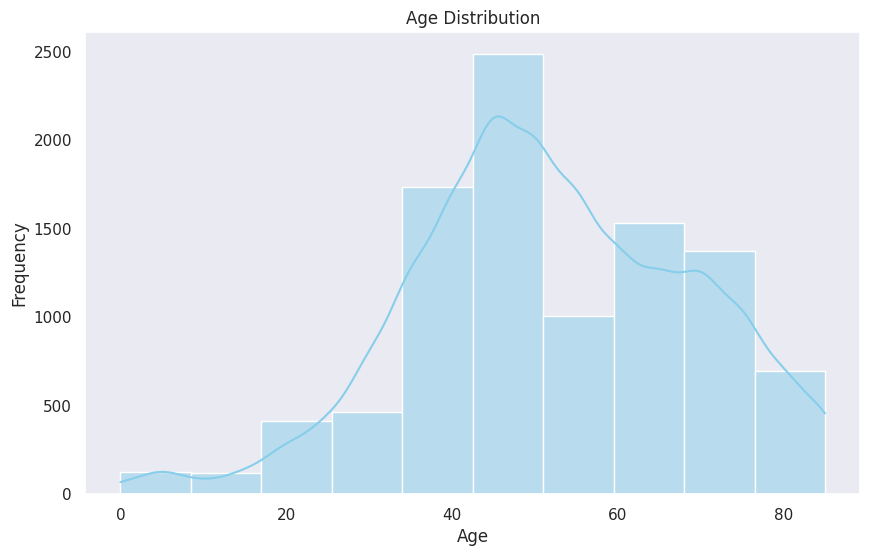

In [12]:
plt.figure(figsize=(10, 6))
sns.histplot(metadata['age'], bins=10, kde=True, color='skyblue')
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.grid()
plt.show()

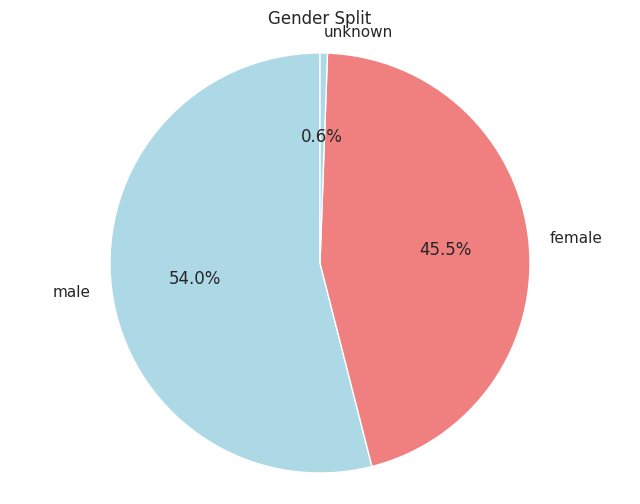

In [13]:
# Count instances of each gender
gender_counts = metadata['sex'].value_counts()

# Plot the gender split
plt.figure(figsize=(8, 6))
plt.pie(gender_counts, labels=gender_counts.index, autopct='%1.1f%%', startangle=90, colors=['lightblue', 'lightcoral'])
plt.title('Gender Split')
plt.axis('equal') 
plt.show()

### Link the pictures and metadata

In [15]:
# List all folders in the Labeled Data directory
image_directory = '/home/jovyan/.cache/kagglehub/datasets/rauf41/skin-cancer-image-dataset/versions/1/Skin Cancer Dataset/Skin Cancer Dataset/Labeled Data'
folders = os.listdir(image_directory)
print(files)

['HAM10000_metadata.csv', 'Skin Cancer Dataset']


In [16]:
print(metadata.isnull().sum())

lesion_id        0
image_id         0
dx               0
dx_type          0
age             57
sex              0
localization     0
dtype: int64


In [17]:
# Convert the columns to strings
metadata['image_id'] = metadata['image_id'].astype(str)
metadata['dx'] = metadata['dx'].astype(str)

for index, row in metadata.iterrows():
    dx = row['dx'] 
    image_id = row['image_id'] + '.jpg' 
    folder_path = os.path.join(image_directory, dx)
    image_path = os.path.join(folder_path, image_id)
    # if os.path.exists(image_path):
    #     print(f"Image found: {image_path}")
    # else:
    #     print(f"Image not found for: {image_id} + {image_path}")


In [18]:
def select_random_images(metadata, image_directory, n_samples=5):
    selected_images = {}
    dx_folders = metadata['dx'].unique()

    for dx in dx_folders:
        dx_metadata = metadata[metadata['dx'] == dx]
        
        num_images_to_sample = min(n_samples, len(dx_metadata)) 
        random_samples = dx_metadata.sample(n=num_images_to_sample, random_state=42)
        
        image_paths = []
        for index, row in random_samples.iterrows():
            image_id = row['image_id'] + '.jpg'  
            folder_path = os.path.join(image_directory, dx)
            image_path = os.path.join(folder_path, image_id)
            if os.path.exists(image_path):
                image_paths.append(image_path)

        selected_images[dx] = image_paths
    
    return selected_images

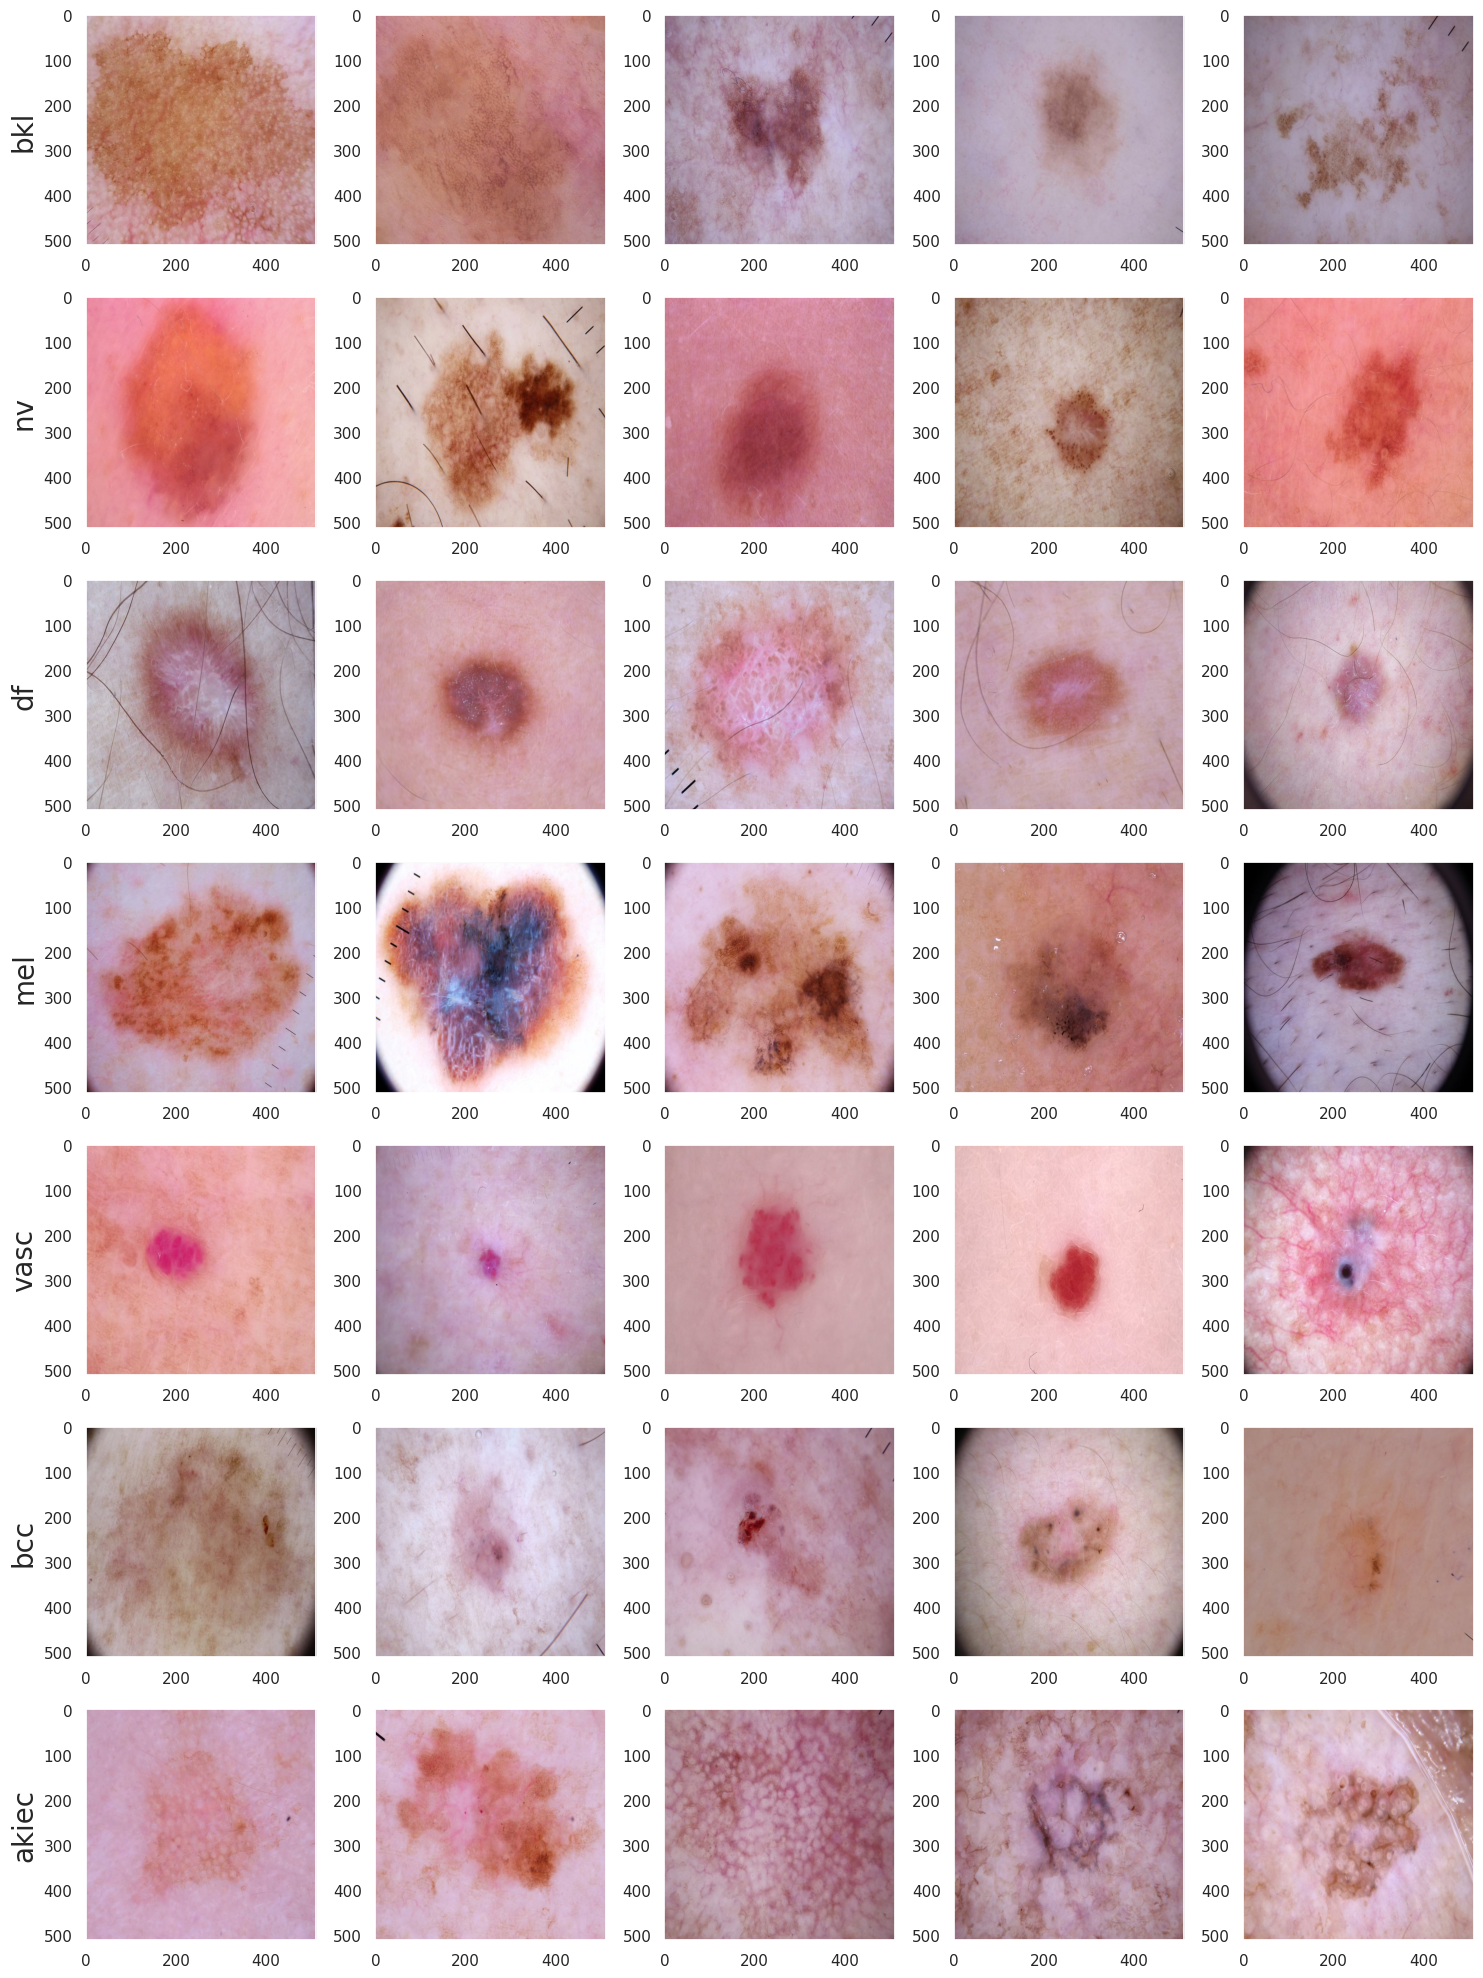

In [19]:
def plot_images(selected_images):
    n_rows = len(selected_images)  
    n_cols = max(len(images) for images in selected_images.values()) 

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 3 * n_rows))

    for row_idx, (dx, image_paths) in enumerate(selected_images.items()):
        for col_idx, image_path in enumerate(image_paths):
            img = Image.open(image_path)
            axes[row_idx, col_idx].imshow(img)
            axes[row_idx, col_idx].axis('on')
            axes[row_idx, col_idx].grid(False)

        for col_idx in range(len(image_paths), n_cols):
            axes[row_idx, col_idx].axis('off')

    for row_idx, dx in enumerate(selected_images.keys()):
        axes[row_idx, 0].set_ylabel(dx, fontsize=20)

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


selected_images = select_random_images(metadata, image_directory, n_samples=5)
plot_images(selected_images)

## Splitting dataset for training, validation and testing <a class="anchor" id="split"></a>

In [3]:
metadata = pd.read_csv('/home/jovyan/.cache/kagglehub/datasets/rauf41/skin-cancer-image-dataset/versions/1/HAM10000_metadata.csv')
image_directory = '/home/jovyan/.cache/kagglehub/datasets/rauf41/skin-cancer-image-dataset/versions/1/Skin Cancer Dataset/Skin Cancer Dataset/Labeled Data'

def link_images_to_metadata(metadata, image_directory):
    metadata['image_path'] = None

    for index, row in metadata.iterrows():
        dx = row['dx']
        image_id = row['image_id'] + '.jpg' 
        folder_path = os.path.join(image_directory, dx)
        image_path = os.path.join(folder_path, image_id)
        
        if os.path.exists(image_path):
            metadata.at[index, 'image_path'] = image_path

    return metadata

linked_metadata = link_images_to_metadata(metadata, image_directory)
linked_metadata.head()

lesion_id      image_id   dx dx_type   age   sex localization  \
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp   
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp   
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp   
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp   
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear   

                                          image_path  
0  /home/jovyan/.cache/kagglehub/datasets/rauf41/...  
1  /home/jovyan/.cache/kagglehub/datasets/rauf41/...  
2  /home/jovyan/.cache/kagglehub/datasets/rauf41/...  
3  /home/jovyan/.cache/kagglehub/datasets/rauf41/...  
4  /home/jovyan/.cache/kagglehub/datasets/rauf41/...

In [4]:
train_df, temp_df = train_test_split(linked_metadata, test_size=0.3, random_state=42, stratify=linked_metadata['dx'])
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42, stratify=temp_df['dx'])

# Display the sizes of the datasets
print(f"Training set size: {len(train_df)}")
print(f"Validation set size: {len(val_df)}")
print(f"Test set size: {len(test_df)}")

# Save the datasets to CSV files
train_df.to_csv('train_metadata.csv', index=False)
val_df.to_csv('val_metadata.csv', index=False)
test_df.to_csv('test_metadata.csv', index=False)

Training set size: 7010
Validation set size: 1502
Test set size: 1503


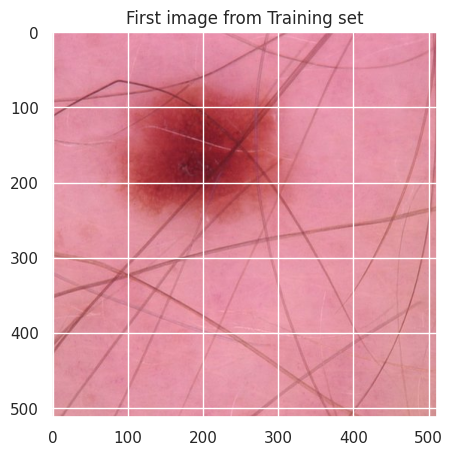

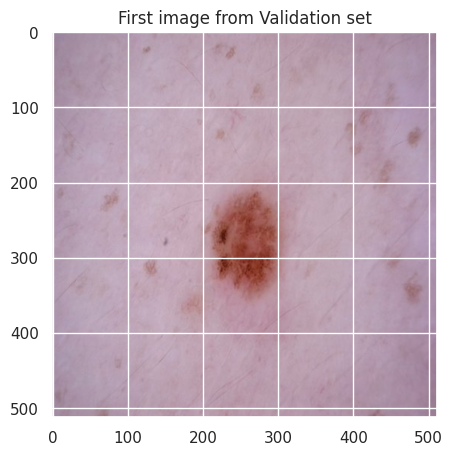

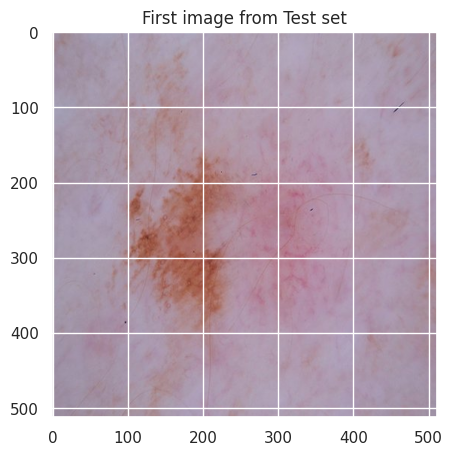

In [22]:
def display_first_image(df, dataset_name):
    image_path = df['image_path'].iloc[0]  # Get the first image path
    img = Image.open(image_path)  # Open the image
    plt.figure(figsize=(5, 5))
    plt.imshow(img)
    plt.axis('on')  # Show axis
    plt.title(f"First image from {dataset_name}")
    plt.show()

# Display the first images from each dataset
display_first_image(train_df, 'Training set')
display_first_image(val_df, 'Validation set')
display_first_image(test_df, 'Test set')

In [5]:
# Load the datasets
train_df = pd.read_csv('train_metadata.csv')
val_df = pd.read_csv('val_metadata.csv')
test_df = pd.read_csv('test_metadata.csv')

print(train_df['image_path'])


0       /home/jovyan/.cache/kagglehub/datasets/rauf41/...
1       /home/jovyan/.cache/kagglehub/datasets/rauf41/...
2       /home/jovyan/.cache/kagglehub/datasets/rauf41/...
3       /home/jovyan/.cache/kagglehub/datasets/rauf41/...
4       /home/jovyan/.cache/kagglehub/datasets/rauf41/...
                              ...                        
7005    /home/jovyan/.cache/kagglehub/datasets/rauf41/...
7006    /home/jovyan/.cache/kagglehub/datasets/rauf41/...
7007    /home/jovyan/.cache/kagglehub/datasets/rauf41/...
7008    /home/jovyan/.cache/kagglehub/datasets/rauf41/...
7009    /home/jovyan/.cache/kagglehub/datasets/rauf41/...
Name: image_path, Length: 7010, dtype: object


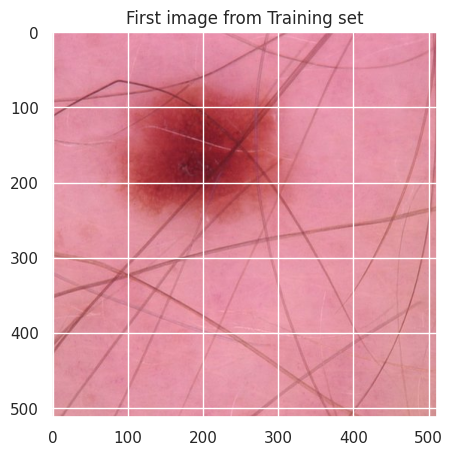

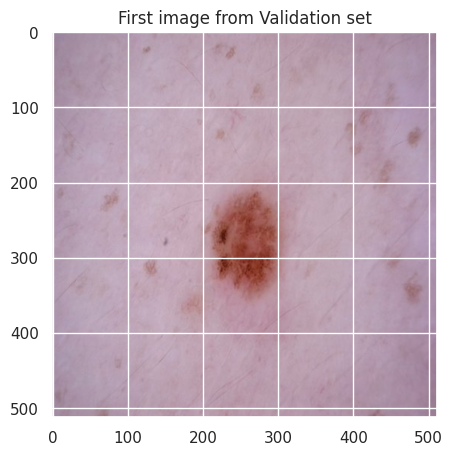

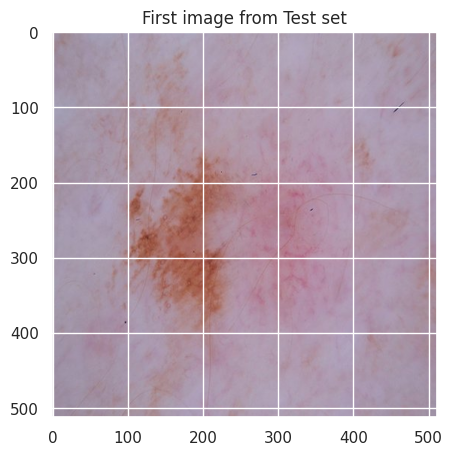

In [24]:
def display_first_image(df, dataset_name):
    image_path = df['image_path'].iloc[0]
    img = Image.open(image_path)
    plt.figure(figsize=(5, 5))
    plt.imshow(img)
    plt.axis('on')  # Keep the axis visible
    plt.title(f"First image from {dataset_name}")
    plt.show()

# Display the first image from each dataset
display_first_image(train_df, 'Training set')
display_first_image(val_df, 'Validation set')
display_first_image(test_df, 'Test set')

## Image Preprocessing <a class="anchor" id="process"></a>

Resize the images and normalize pixel values to prepare them for training.

In [6]:
def preprocess_image(img_path):
    img = cv2.imread(img_path)
    if img is None:
        raise ValueError(f"Image at path '{img_path}' could not be loaded.")
    img = cv2.resize(img, (128, 128))
    
    # Normalize the pixel values to range [0, 1]
    img = img / 255.0
    img = (img * 255).astype(np.uint8)  
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    return img

X_train = np.array([preprocess_image(img_path) for img_path in train_df['image_path']])
y_train = train_df['dx'].values

X_val = np.array([preprocess_image(img_path) for img_path in val_df['image_path']])
y_val = val_df['dx'].values

X_test = np.array([preprocess_image(img_path) for img_path in test_df['image_path']])
y_test = test_df['dx'].values


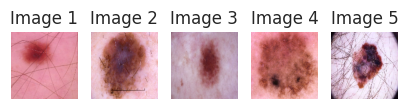

In [26]:
# Function to display a few images
def display_images(images, n=5):
    plt.figure(figsize=(5, 5))
    for i in range(n):
        plt.subplot(1, n, i + 1)
        plt.imshow(images[i])
        plt.axis('off')  # Hide axis
        plt.title(f"Image {i + 1}")
    plt.show()

# Displaying the first 5 processed images from the training set
display_images(X_train, n=5)

In [27]:
# Check shape and data type of images in X_train
for i in range(5):
    img = Image.fromarray((X_train[i] * 255).astype(np.uint8))
    print(f"Image index: {i}, Size: {img.size}, Mode: {img.mode}")


Image index: 0, Size: (128, 128), Mode: RGB
Image index: 1, Size: (128, 128), Mode: RGB
Image index: 2, Size: (128, 128), Mode: RGB
Image index: 3, Size: (128, 128), Mode: RGB
Image index: 4, Size: (128, 128), Mode: RGB


Convert the string labels into numerical format

In [7]:
label_encoder = LabelEncoder()

y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)
y_test_encoded = label_encoder.transform(y_test)

class_mappings = dict(zip(label_encoder.classes_, range(len(label_encoder.classes_))))
print("Class mappings:", class_mappings)


Class mappings: {'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}


## Training, validating and testing CNN <a class="anchor" id="cnn"></a>

 defining and compiling your CNN model in TensorFlow

In [29]:
num_classes = len(label_encoder.classes_)

cnn_model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, activation='softmax')  # Output layer for number of classes
])

cnn_model.compile(optimizer='adam', 
                  loss='sparse_categorical_crossentropy', 
                  metrics=['accuracy'])

cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 128)      0

train the model

In [30]:
# Train the model
training_history = cnn_model.fit(X_train, y_train_encoded, 
                                  validation_data=(X_val, y_val_encoded), 
                                  epochs=10, 
                                  batch_size=32)


Epoch 1/10


2024-10-20 08:25:31.617386: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 344555520 exceeds 10% of free system memory.


220/220 [==============================] - 1094s 5s/step - loss: 2.8116 - accuracy: 0.6485 - val_loss: 0.9469 - val_accuracy: 0.6704
Epoch 2/10
220/220 [==============================] - 192s 870ms/step - loss: 0.9015 - accuracy: 0.6796 - val_loss: 0.9123 - val_accuracy: 0.6917
Epoch 3/10
220/220 [==============================] - 185s 839ms/step - loss: 0.8243 - accuracy: 0.6974 - val_loss: 0.8601 - val_accuracy: 0.7024
Epoch 4/10
220/220 [==============================] - 212s 965ms/step - loss: 0.7670 - accuracy: 0.7167 - val_loss: 0.8482 - val_accuracy: 0.7091
Epoch 5/10
220/220 [==============================] - 166s 754ms/step - loss: 0.7066 - accuracy: 0.7405 - val_loss: 0.8602 - val_accuracy: 0.6911
Epoch 6/10
220/220 [==============================] - 177s 804ms/step - loss: 0.6342 - accuracy: 0.7631 - val_loss: 0.8920 - val_accuracy: 0.6977
Epoch 7/10
220/220 [==============================] - 241s 1s/step - loss: 0.6580 - accuracy: 0.7633 - val_loss: 0.9684 - val_accuracy: 0

Augmenting training data:
By applying transformations like rotation, flipping, zooming, and shifting, I can introduce more variety and help my model generalize better to unseen data. It's like expanding my training set without collecting more images.

In [31]:
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

datagen.fit(X_train)

training_history = cnn_model.fit(datagen.flow(X_train, y_train_encoded, batch_size=32), 
                                  validation_data=(X_val, y_val_encoded), 
                                  epochs=20)

Epoch 1/20
220/220 [==============================] - 175s 793ms/step - loss: 0.9822 - accuracy: 0.6611 - val_loss: 0.8866 - val_accuracy: 0.6791
Epoch 2/20
220/220 [==============================] - 197s 895ms/step - loss: 0.8931 - accuracy: 0.6790 - val_loss: 0.9203 - val_accuracy: 0.6831
Epoch 4/20
220/220 [==============================] - 173s 787ms/step - loss: 0.8818 - accuracy: 0.6826 - val_loss: 0.8381 - val_accuracy: 0.6951
Epoch 5/20
220/220 [==============================] - 182s 827ms/step - loss: 0.8375 - accuracy: 0.6906 - val_loss: 0.8731 - val_accuracy: 0.6864
Epoch 6/20
220/220 [==============================] - 184s 838ms/step - loss: 0.8191 - accuracy: 0.6979 - val_loss: 0.8409 - val_accuracy: 0.6924
Epoch 7/20
220/220 [==============================] - 174s 790ms/step - loss: 0.8187 - accuracy: 0.6940 - val_loss: 0.8237 - val_accuracy: 0.6957
Epoch 8/20
220/220 [==============================] - 173s 787ms/step - loss: 0.8196 - accuracy: 0.7009 - val_loss: 0.8409 -

In [36]:
# Evaluate the model on the test dataset
test_loss, test_accuracy = cnn_model.evaluate(X_test, y_test_encoded)

# Print the test accuracy
print(f'Test Accuracy: {test_accuracy:.2f}')

47/47 [==============================] - 11s 237ms/step - loss: 0.7985 - accuracy: 0.7119
Test Accuracy: 0.71


In [34]:
# Make predictions on the test dataset
predictions = cnn_model.predict(X_test)

predicted_classes = np.argmax(predictions, axis=1)
predicted_labels = label_encoder.inverse_transform(predicted_classes)

for i in range(5):
    print(f"Predicted: {predicted_labels[i]}, True: {y_test[i]}")


47/47 [==============================] - 11s 236ms/step
Predicted: nv, True: bkl
Predicted: bkl, True: nv
Predicted: nv, True: nv
Predicted: nv, True: nv
Predicted: nv, True: nv


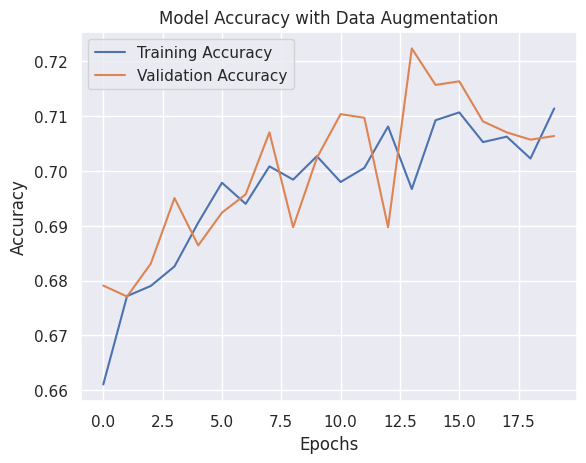

In [35]:
# Plotting the training and validation accuracy
plt.plot(training_history.history['accuracy'], label='Training Accuracy')
plt.plot(training_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy with Data Augmentation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
def build_model(hp):
    model = models.Sequential()
    
    model.add(layers.Conv2D(
        filters=hp.Int('conv_1_filters', min_value=32, max_value=128, step=32),
        kernel_size=(3, 3), activation='relu', input_shape=(128, 128, 3),
        kernel_regularizer=regularizers.l2(hp.Float('l2_reg', min_value=1e-4, max_value=1e-2, sampling='LOG'))))
    
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    

    model.add(layers.Conv2D(
        filters=hp.Int('conv_2_filters', min_value=32, max_value=128, step=32),
        kernel_size=(3, 3), activation='relu',
        kernel_regularizer=regularizers.l2(hp.Float('l2_reg', min_value=1e-4, max_value=1e-2, sampling='LOG'))))
    
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.Flatten())
    model.add(layers.Dense(
        units=hp.Int('dense_units', min_value=64, max_value=512, step=64), 
        activation='relu',
        kernel_regularizer=regularizers.l2(hp.Float('l2_reg', min_value=1e-4, max_value=1e-2, sampling='LOG'))))
    

    model.add(layers.Dropout(rate=hp.Float('dropout', min_value=0.2, max_value=0.5, step=0.1)))
    model.add(layers.Dense(7, activation='softmax')) 
    
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy'])
    
    return model

class ClearSessionCallback(tf.keras.callbacks.Callback):
    def on_trial_end(self, trial):
        K.clear_session()

tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=2,
    directory='my_dir',
    project_name='cnn_tuning'
)

tuner.search(X_train, y_train_encoded, 
             epochs=10,
             validation_data=(X_val, y_val_encoded),
             callbacks=[ClearSessionCallback()]) 

Reloading Tuner from my_dir/cnn_tuning/tuner0.json

Search: Running Trial #2

Value             |Best Value So Far |Hyperparameter
64                |32                |conv_1_filters
128               |32                |conv_2_filters
128               |320               |dense_units
0.3               |0.3               |dropout

Epoch 1/10


2024-10-20 15:33:50.666771: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 344555520 exceeds 10% of free system memory.


 20/220 [=>............................] - ETA: 4:54 - loss: 265.0593 - accuracy: 0.4922

## Conclusion <a class="anchor" id="conclusion"></a>

The training and validation results from this model suggest the following:

* The model shows a gradual improvement in training accuracy, reaching around 71% by the 20th epoch. Validation accuracy follows a similar trend, hovering around 70-72%.
* Both the training and validation losses decrease over time, but not as significantly as expected, indicating the model may have hit a performance plateau.
* The test accuracy (71%) is consistent with the validation accuracy, indicating that the model generalizes reasonably well to unseen data but could still be improved.
* The training and validation loss values are still relatively high, and there's only a slight gap between training and validation accuracy. This suggests the model is neither overfitting nor underfitting significantly but could benefit from further tuning.

Possible improvements:

* Further Hyperparameter Tuning: Adjust learning rate, batch size, or optimizer.
* Model Complexity: Consider deeper models with additional layers or more sophisticated architectures like transfer learning from a pre-trained model.
* Data Augmentation: Already used but could be increased for better generalization.
* More Training: Training for additional epochs to see if performance continues to improve.

The current results are promising, but additional steps can further boost the model's performance.